# 03 – Model Training & Evaluation

## 1. Introduction

In this notebook, we train machine learning models for the
Cardiovascular Disease Risk Prediction System.

## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## 3. Load Preprocessed Data

In [5]:
data = pd.read_csv("../data/processed/cleaned_data.csv")

X = data.drop(columns = ["cardio", "id"])
y = data["cardio"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# PART A — Model From Scratch (No Libraries)

## 4. Build Logistic Regression From Scratch

### 4.1 Sigmoid Function

In [6]:
# RuntimeWarning: overflow encountered in exp
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

def sigmoid(z):
    z = np.clip(z, -500, 500)      # Prevent overflow
    return 1 / (1 + np.exp(-z))

### 4.2 Custom Logistic Regression Class

In [7]:
class CustomLogisticRegression:
    def __init__(self, lr = 0.01, epochs = 1000):
        # lr: learning rate — controls how big the weight updates are.
        # epochs: number of times the algorithm loops through the entire training set.
        self.lr = lr
        self.epochs = epochs
        
    def fit(self, X, y):
        # Add a bias term (column of 1s) to the feature matrix.
        X = np.insert(X, 0, 1, axis = 1)
        
        # Initialize weights to zeros (one weight per feature + bias).
        self.weights = np.zeros(X.shape[1])
        
        # Gradient descent loop for the specified number of epochs.
        for _ in range(self.epochs):
            # Linear combination of inputs and weights.
            z = np.dot(X, self.weights)
            
            # Apply the sigmoid function to get probabilities.
            y_pred = sigmoid(z)
            
            # Compute the gradient of the loss with respect to the weights.
            gradient = np.dot(X.T, (y_pred - y)) / y.size
            
            # Update weights using gradient descent.
            self.weights -= self.lr * gradient
    
    def predict(self, X):
        # Add the bias term to the input data (same as during training).
        X = np.insert(X, 0, 1, axis = 1)
        
        # Compute probabilities using the sigmoid of the linear combination.
        probabilities = sigmoid(np.dot(X, self.weights))
        
        # Convert probabilities to binary predictions (0 or 1) using threshold 0.5.
        return (probabilities >= 0.5).astype(int)

## 5. Train Custom Model

In [8]:
X_train_np = X_train.values
X_test_np = X_test.values

model_scratch = CustomLogisticRegression(lr = 0.01, epochs = 1500)
model_scratch.fit(X_train_np, y_train)

## 6. Evaluate Custom Model

In [9]:
y_pred_scratch = model_scratch.predict(X_test_np)

# Print the accuracy of the model: 
# Accuracy = (Number of correct predictions) / (Total predictions)
print("Accuracy:", accuracy_score(y_test, y_pred_scratch))

# Print the precision of the model:
# Precision = True Positives / (True Positives + False Positives)
# Measures how many predicted positives are actually positive.
print("Precision:", precision_score(y_test, y_pred_scratch))

# Print the recall of the model:
# Recall = True Positives / (True Positives + False Negatives)
# Measures how many actual positives were correctly predicted.
print("Recall:", recall_score(y_test, y_pred_scratch))

# Print the F1 score of the model:
# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
# Harmonic mean of precision and recall; balances both metrics.
print("F1 Score:", f1_score(y_test, y_pred_scratch))

Accuracy: 0.5908329082562122
Precision: 0.8300506471581317
Recall: 0.21729522687094874
F1 Score: 0.344424985405721


# PART B — Random Forest (Best Performing Model)

## 7. Feature Scaling

In [11]:
num_cols = ['height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'age_years']

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

scaler = StandardScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

## 8. Train Random Forest Model

In [12]:
rf = RandomForestClassifier(
    n_estimators = 300,
    max_depth = 12,
    min_samples_split = 4,
    random_state = 42,
    class_weight = "balanced"
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,12
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 9. Predictions

In [15]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1] # proba is probabilities

## 10. Evaluation Metrics

In [17]:
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))

# zero_division = 0 prevents warnings if some classes have no predicted samples (optional to add in classification_report)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy : 0.7373752095022954
Precision: 0.7560308780958508
Recall   : 0.6925456688273424
F1 Score : 0.7228971244041211

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6935
           1       0.76      0.69      0.72      6788

    accuracy                           0.74     13723
   macro avg       0.74      0.74      0.74     13723
weighted avg       0.74      0.74      0.74     13723



## 11. Confusion Matrix

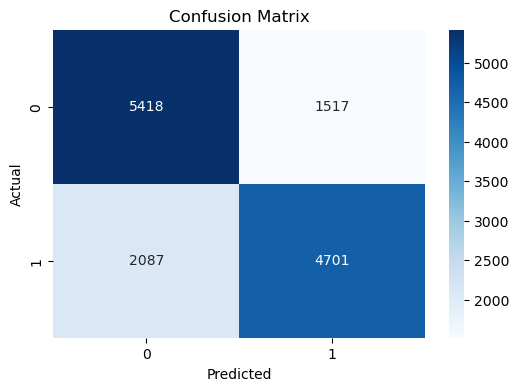

In [18]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues') # fmt is format of the annotations
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 12. ROC–AUC Curve

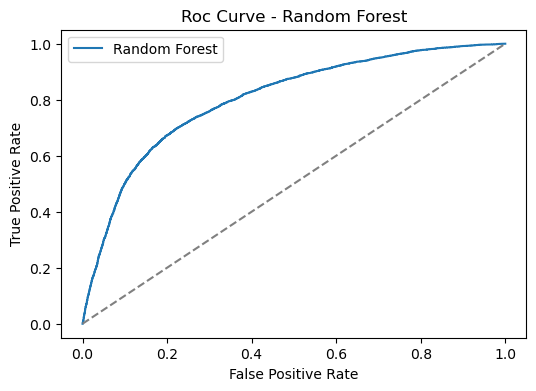

ROC AUC Score: 0.8030467163096673


In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = "Random Forest")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Roc Curve - Random Forest")
plt.legend()
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

## 13. Best Classification Threshold (Youden’s J)

In [21]:
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.4f}")

Best threshold: 0.4952


## 14. Save Model, Scaler, Threshold

In [22]:
joblib.dump(rf, "../models/best_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(best_threshold, "../models/threshold.pkl")

print("Model, scaler, and threshold saved successfully!")

Model, scaler, and threshold saved successfully!


## 15. Conclusion

### Model Training Completed

- Logistic Regression from scratch implemented  
- Random Forest trained using scaled features  
- Evaluated using Accuracy, Precision, Recall, F1  
- Confusion Matrix and ROC–AUC included  
- Best threshold identified using Youden’s J  
- Saved:
  - best_model.pkl
  - scaler.pkl
  - threshold.pkl